In [1]:
import argparse
import logging
import numpy as np
import pyvista as pv

from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    process_folds,
    plot_mesh_folds,
    persist_best_iteration,
    load_best_iteration,
    crop_meshes_per_fold,
    save_splits
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler("park_row")
dh.ensure_meshes()

20:45:23 - INFO - Label park_row already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

20:45:24 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
20:45:24 - INFO - Sampling with resolution 0.15.
20:45:24 - INFO - Number of points after initial sampling: 8870916
20:45:27 - INFO - Number of points after Poisson Disk Sampling: 461770
20:45:28 - INFO - Number of points after initial sampling: 1246176
20:45:28 - INFO - Number of points after Poisson Disk Sampling: 204398
20:45:28 - INFO - Number of points after initial sampling: 1176628
20:45:28 - INFO - Number of points after Poisson Disk Sampling: 65777
20:45:29 - INFO - Number of points after initial sampling: 3485817
20:45:30 - INFO - Number of points after Poisson Disk Sampling: 134444
20:45:30 - INFO - Number of points after initial sampling: 613094
20:45:30 - INFO - Number of points after Poisson Disk Sampling: 104626
20:45:30 - INFO - Number of points after initial s

In [5]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

20:45:31 - INFO - Binning is using 5 bins in X and 19 bins in Y based on cell widths of 6.0 and 6.0.


20:45:31 - INFO - New best equality score: 2028354.7791 at iteration 1
20:45:31 - INFO - New best equality score: 34444.2790 at iteration 2
20:45:31 - INFO - New best equality score: 13755.9269 at iteration 20
20:45:32 - INFO - New best equality score: 6544.6926 at iteration 112
20:45:33 - INFO - 
Best equality score after 1000 iterations: 6544.6926
20:45:33 - INFO - Best iteration: 112
20:45:33 - INFO - 
Final category counts and percentages per area:

Area 1:
  Area size: 63 cells (66.32% of total, intended 65.00%)
  1_WALL: 319361 points (69.16% ± 0.07% of total 1_WALL)
  2_FLOOR: 140242 points (68.61% ± 0.10% of total 2_FLOOR)
  3_ROOF: 50101 points (76.17% ± 0.17% of total 3_ROOF)
  4_CEILING: 84734 points (63.03% ± 0.13% of total 4_CEILING)
  5_FOOTPATH: 60205 points (57.54% ± 0.15% of total 5_FOOTPATH)
  6_GRASS: 18406 points (70.84% ± 0.28% of total 6_GRASS)
  7_COLUMN: 23737 points (67.14% ± 0.25% of total 7_COLUMN)
  8_DOOR: 11148 points (78.13% ± 0.35% of total 8_DOOR)
  9_W

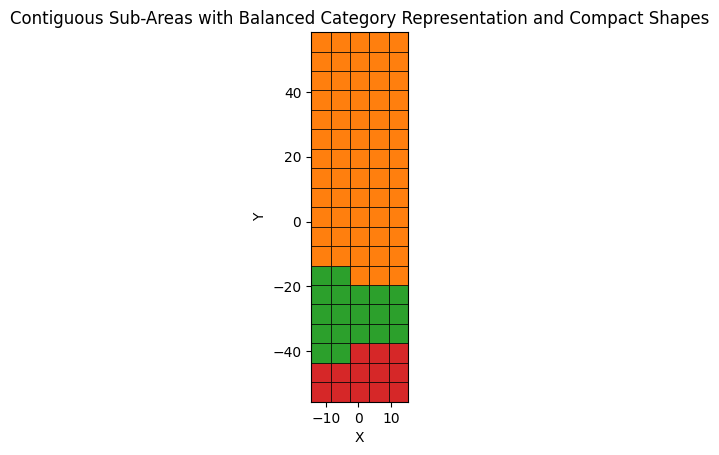

In [6]:
weights = [0.65, 0.2, 0.15]  # Intended area weights: training, evaluation, test
iterations = 1000  # Number of iterations to run
min_percentage_threshold = 8  # Minimum acceptable percentage per category per area
verbose = True  # Whether to print detailed statistics

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    min_percentage_threshold=min_percentage_threshold,
    verbose=verbose
)

# Run the algorithm
grid_splitter.run(random_seed=9897853)

# Plot the result
grid_splitter.plot()

Processing Fold 1
Fold 1 has 2 rectangles with total perimeter 42.


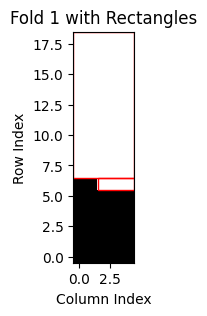

Processing Fold 2
Fold 2 has 3 rectangles with total perimeter 28.


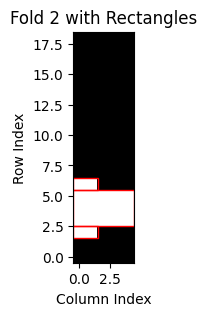

Processing Fold 3
Fold 3 has 2 rectangles with total perimeter 22.


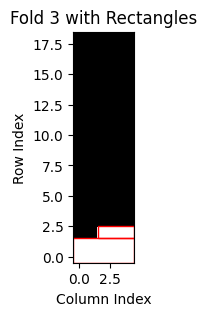

In [7]:
# Process the folds and get the rectangles
fold_rectangles = process_folds(grid_splitter.best_grid)

In [8]:
persist_best_iteration(gridsplitter=grid_splitter, fold_rectangles=fold_rectangles, filename='brass_foundry_3fold.pkl')

Data from the best iteration has been saved to brass_foundry_3fold.pkl


In [9]:
loaded_data = load_best_iteration('brass_foundry_3fold.pkl')

20:45:34 - INFO - Best Iteration: 112
20:45:34 - INFO - Best Equality Score: 6544.6926
20:45:34 - INFO - 
Final category counts per area:

Area 1:
  Area size: 63 cells (66.32% of total, intended 65.00%)
  1_WALL: 319361 points (69.16% of total 1_WALL)
  2_FLOOR: 140242 points (68.61% of total 2_FLOOR)
  3_ROOF: 50101 points (76.17% of total 3_ROOF)
  4_CEILING: 84734 points (63.03% of total 4_CEILING)
  5_FOOTPATH: 60205 points (57.54% of total 5_FOOTPATH)
  6_GRASS: 18406 points (70.84% of total 6_GRASS)
  7_COLUMN: 23737 points (67.14% of total 7_COLUMN)
  8_DOOR: 11148 points (78.13% of total 8_DOOR)
  9_WINDOW: 11393 points (60.18% of total 9_WINDOW)
  10_STAIR: 6447 points (69.39% of total 10_STAIR)
  11_RAILING: 3410 points (54.04% of total 11_RAILING)
  12_RWP: 473 points (57.47% of total 12_RWP)
  13_OTHER: 4429 points (65.88% of total 13_OTHER)
  Total points in area: 734086

Area 2:
  Area size: 19 cells (20.00% of total, intended 20.00%)
  1_WALL: 67889 points (14.70% of to

Data from brass_foundry_3fold.pkl has been loaded successfully.


In [10]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    loaded_data['fold_rectangles'],
    loaded_data['x_edges'],
    loaded_data['y_edges']
)

20:45:34 - INFO - Processing Fold 1
20:45:42 - INFO - Processing Fold 2
20:45:58 - INFO - Processing Fold 3


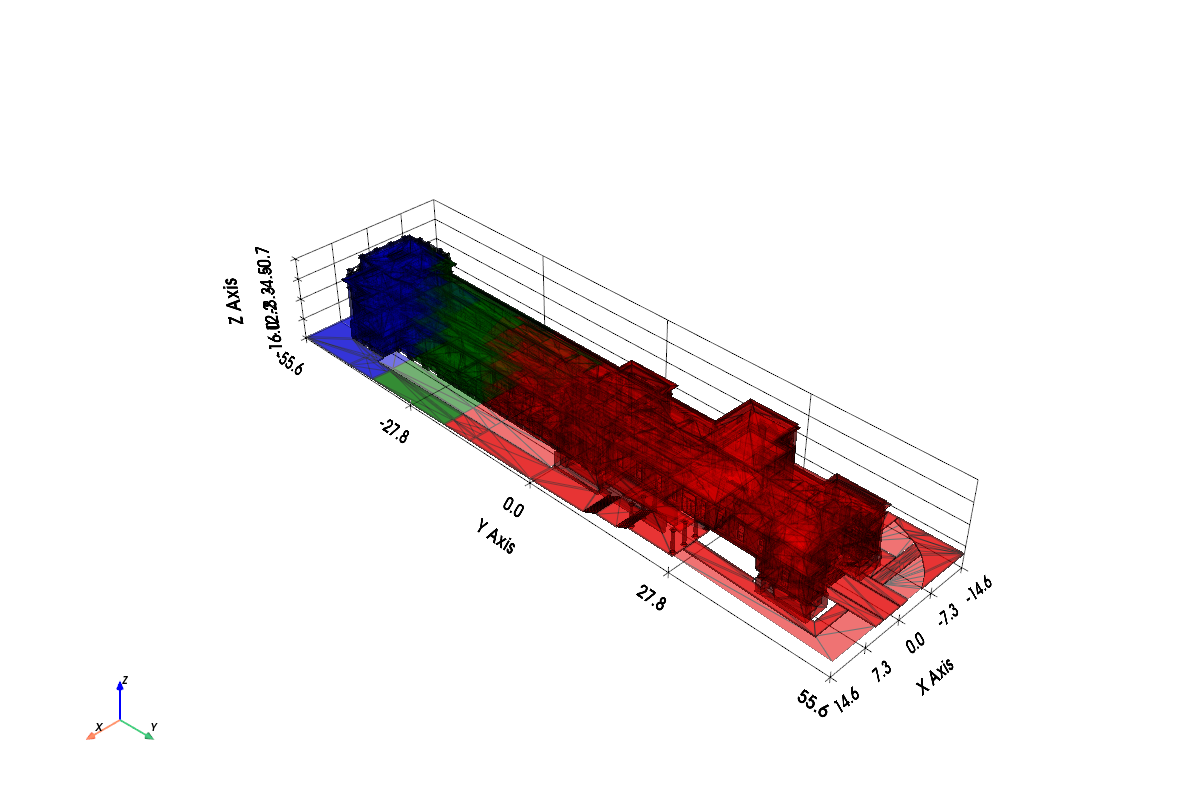

In [11]:
plot_mesh_folds(fold_meshes)

In [12]:
fold_meshes[1]['1_WALL']

PolyData (0x7a344ac604c0)
  N Cells:    181899
  N Points:   107960
  N Strips:   0
  X Bounds:   -1.200e+01, 1.033e+01
  Y Bounds:   -1.959e+01, 4.832e+01
  Z Bounds:   -1.572e+01, -3.059e+00
  N Arrays:   2

In [13]:
fold_name_map = {
    1: 'train',
    2: 'test',
    3: 'eval',
}

fold_meshes_2 = {fold_name_map[k]: v for k, v in fold_meshes.items()}
fold_meshes_2

{'train': {'1_WALL': PolyData (0x7a344ac604c0)
    N Cells:    181899
    N Points:   107960
    N Strips:   0
    X Bounds:   -1.200e+01, 1.033e+01
    Y Bounds:   -1.959e+01, 4.832e+01
    Z Bounds:   -1.572e+01, -3.059e+00
    N Arrays:   2,
  '2_FLOOR': PolyData (0x7a344ac60460)
    N Cells:    12179
    N Points:   8041
    N Strips:   0
    X Bounds:   -1.074e+01, 9.085e+00
    Y Bounds:   -1.959e+01, 4.706e+01
    Z Bounds:   -1.573e+01, -4.879e+00
    N Arrays:   2,
  '3_ROOF': PolyData (0x7a344ac60940)
    N Cells:    359
    N Points:   214
    N Strips:   0
    X Bounds:   -1.096e+01, 1.460e+01
    Y Bounds:   -1.959e+01, 4.705e+01
    Z Bounds:   -7.817e+00, -1.429e+00
    N Arrays:   2,
  '4_CEILING': PolyData (0x7a344ac60ca0)
    N Cells:    17438
    N Points:   5187
    N Strips:   0
    X Bounds:   -1.037e+01, 9.085e+00
    Y Bounds:   -1.959e+01, 4.707e+01
    Z Bounds:   -1.333e+01, -3.680e+00
    N Arrays:   2,
  '5_FOOTPATH': PolyData (0x7a344ac62140)
    N Cells: 

In [14]:
save_splits(dh, fold_meshes_2)

20:46:08 - INFO - Fold train, category 1_WALL saved.
20:46:08 - INFO - Fold train, category 2_FLOOR saved.
20:46:08 - INFO - Fold train, category 3_ROOF saved.
20:46:08 - INFO - Fold train, category 4_CEILING saved.
20:46:08 - INFO - Fold train, category 5_FOOTPATH saved.
20:46:08 - INFO - Fold train, category 6_GRASS saved.
20:46:08 - INFO - Fold train, category 7_COLUMN saved.
20:46:08 - INFO - Fold train, category 8_DOOR saved.
20:46:08 - INFO - Fold train, category 9_WINDOW saved.
20:46:08 - INFO - Fold train, category 10_STAIR saved.
20:46:08 - INFO - Fold train, category 11_RAILING saved.
20:46:08 - INFO - Fold train, category 12_RWP saved.
20:46:08 - INFO - Fold train, category 13_OTHER saved.
20:46:08 - INFO - Fold test, category 1_WALL saved.
20:46:08 - INFO - Fold test, category 2_FLOOR saved.
20:46:08 - INFO - Fold test, category 3_ROOF saved.
20:46:08 - INFO - Fold test, category 4_CEILING saved.
20:46:08 - INFO - Fold test, category 5_FOOTPATH saved.
20:46:08 - INFO - Fold

In [15]:
dh.generate_and_save_fold_clouds(resolution=0.02, poisson_radius=0.05, save_all_formats=True)

20:46:13 - INFO - Number of points after initial sampling: 246452348
20:47:35 - INFO - Number of points after Poisson Disk Sampling: 2453036
20:47:37 - INFO - Saving cloud as .las format...
20:47:40 - INFO - Saved as: ../data/clouds/res0.02_pr0.05/park_row/train/1_wall.las
20:47:40 - INFO - Saved point cloud to ../data/clouds/res0.02_pr0.05/park_row/train/1_wall.pth in .pth format.
20:47:40 - INFO - Number of points after initial sampling: 28654330
20:47:53 - INFO - Number of points after Poisson Disk Sampling: 888559
20:47:53 - INFO - Saving cloud as .las format...
20:47:54 - INFO - Saved as: ../data/clouds/res0.02_pr0.05/park_row/train/2_floor.las
20:47:54 - INFO - Saved point cloud to ../data/clouds/res0.02_pr0.05/park_row/train/2_floor.pth in .pth format.
20:47:54 - INFO - Number of points after initial sampling: 26550250
20:48:02 - INFO - Number of points after Poisson Disk Sampling: 440766
20:48:02 - INFO - Saving cloud as .las format...
20:48:03 - INFO - Saved as: ../data/clouds